In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [5]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

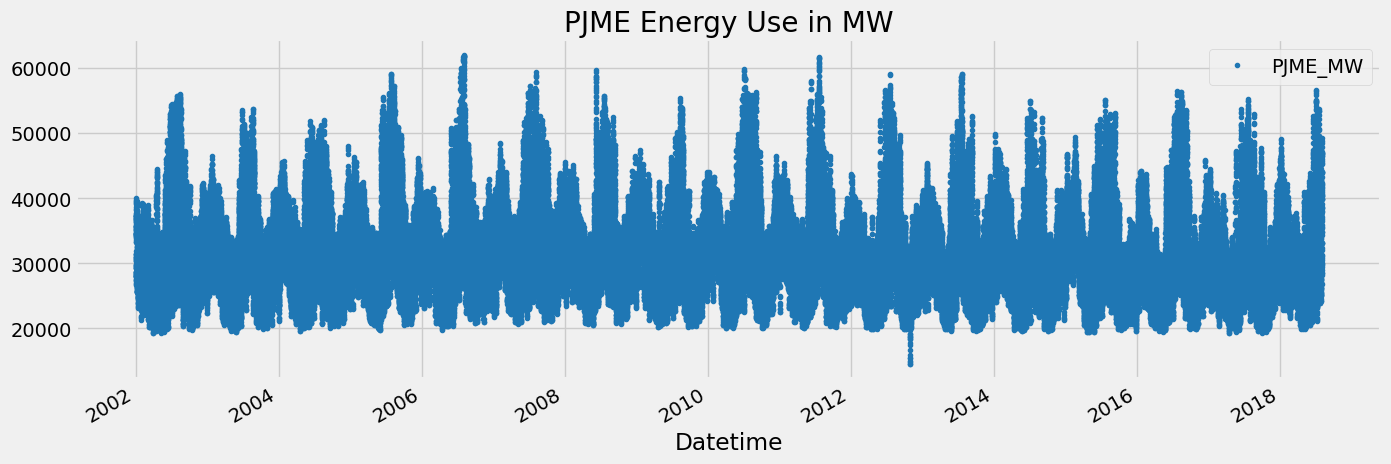

In [6]:
df.plot(style = '.', 
        figsize=(15,5), 
        color=color[0], 
        title='PJME Energy Use in MW')

In [7]:
pd.to_datetime(df.index)

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

# Train/Test Split


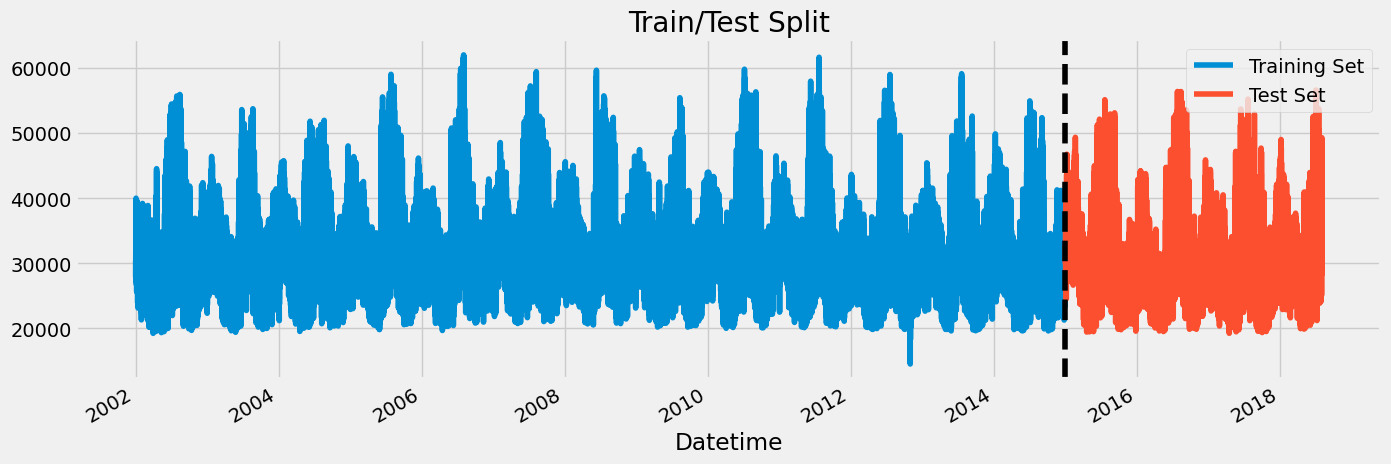

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

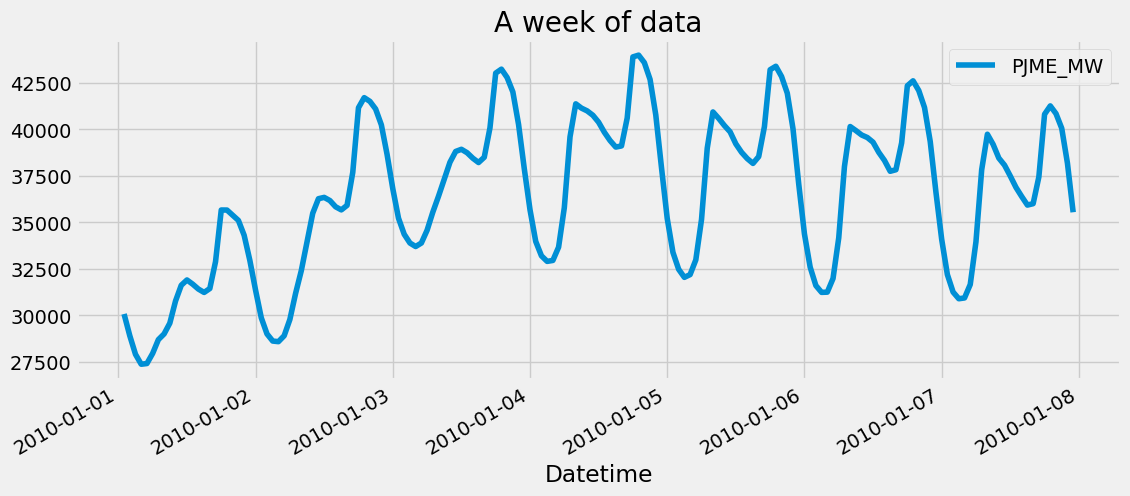

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(12,5), title="A week of data")
plt.show()

# Feature Creation

In [10]:
def create_features(df):
    '''
    Create time series features based on time series index
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week  #monday = 0, sunday = 6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [11]:
df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


# Visualize our Feature / Target Relationship

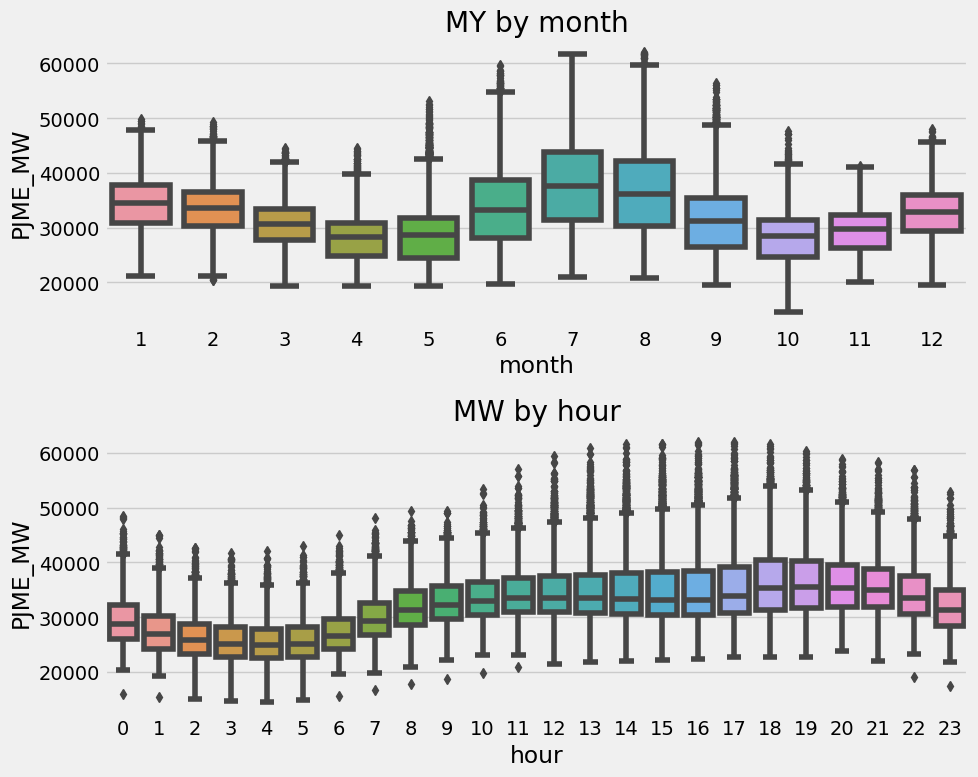

In [12]:
fig , ax = plt.subplots(nrows=2, 
                        ncols=1, 
                        figsize=(10,8))

sns.boxplot(data=df, 
            x='hour', 
            y='PJME_MW',
            ax=ax[1])
ax[1].set_title('MW by hour')

sns.boxplot(data=df, 
            x='month', 
            y='PJME_MW', 
            ax=ax[0])
ax[0].set_title('MY by month')

plt.tight_layout()
plt.show()

# Create Model

In [13]:
train = create_features(train)
test = create_features(test)
FEATURES = ['hour','dayofweek','quarter','month','year','dayofyear']
TARGET = 'PJME_MW'

In [14]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.001)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose =100)

[0]	validation_0-rmse:6447.78573	validation_1-rmse:6517.54145
[100]	validation_0-rmse:6026.49339	validation_1-rmse:6131.08053
[200]	validation_0-rmse:5654.75124	validation_1-rmse:5796.65490
[300]	validation_0-rmse:5326.88030	validation_1-rmse:5505.59274
[400]	validation_0-rmse:5039.56899	validation_1-rmse:5253.21086
[500]	validation_0-rmse:4788.58887	validation_1-rmse:5034.74880
[600]	validation_0-rmse:4565.97498	validation_1-rmse:4847.76655
[700]	validation_0-rmse:4372.19812	validation_1-rmse:4687.11295
[800]	validation_0-rmse:4202.53312	validation_1-rmse:4547.57144
[900]	validation_0-rmse:4055.65261	validation_1-rmse:4427.00726
[999]	validation_0-rmse:3929.32983	validation_1-rmse:4325.35302


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)